## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step 1 : Camera calibration using chessboard images

In [190]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [191]:
def show_image(img_src, title_src, img_dst, title_dst,cmap = None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    f.tight_layout()
    ax1.imshow(img_src)
    ax1.set_title(title_src, fontsize=20)
    ax2.imshow(img_dst,cmap)
    ax2.set_title(title_dst, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [192]:
def save(objpoints,imgpoints):
    # Save the camera calibration result
    dist_pickle = {}
    dist_pickle["objpoints"] = objpoints
    dist_pickle["imgpoints"] = imgpoints
    pickle_out = open("camera_cal/cal_dist_pickle.p","wb")
    pickle.dump(dist_pickle, pickle_out)
    pickle_out.close()

In [193]:
def corner_detection():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    figure = plt.figure(figsize=(20, 20))

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx,fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            idx+=1
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #write file in output_images folder
            #cv2.imwrite('output_images/calibrated{}.jpg'.format(str(idx)),img)
            #save objpoints and imgpoints in pickle file
            save(objpoints,imgpoints)
            figure.add_subplot(5,4,idx)
            plt.imshow(img)
        


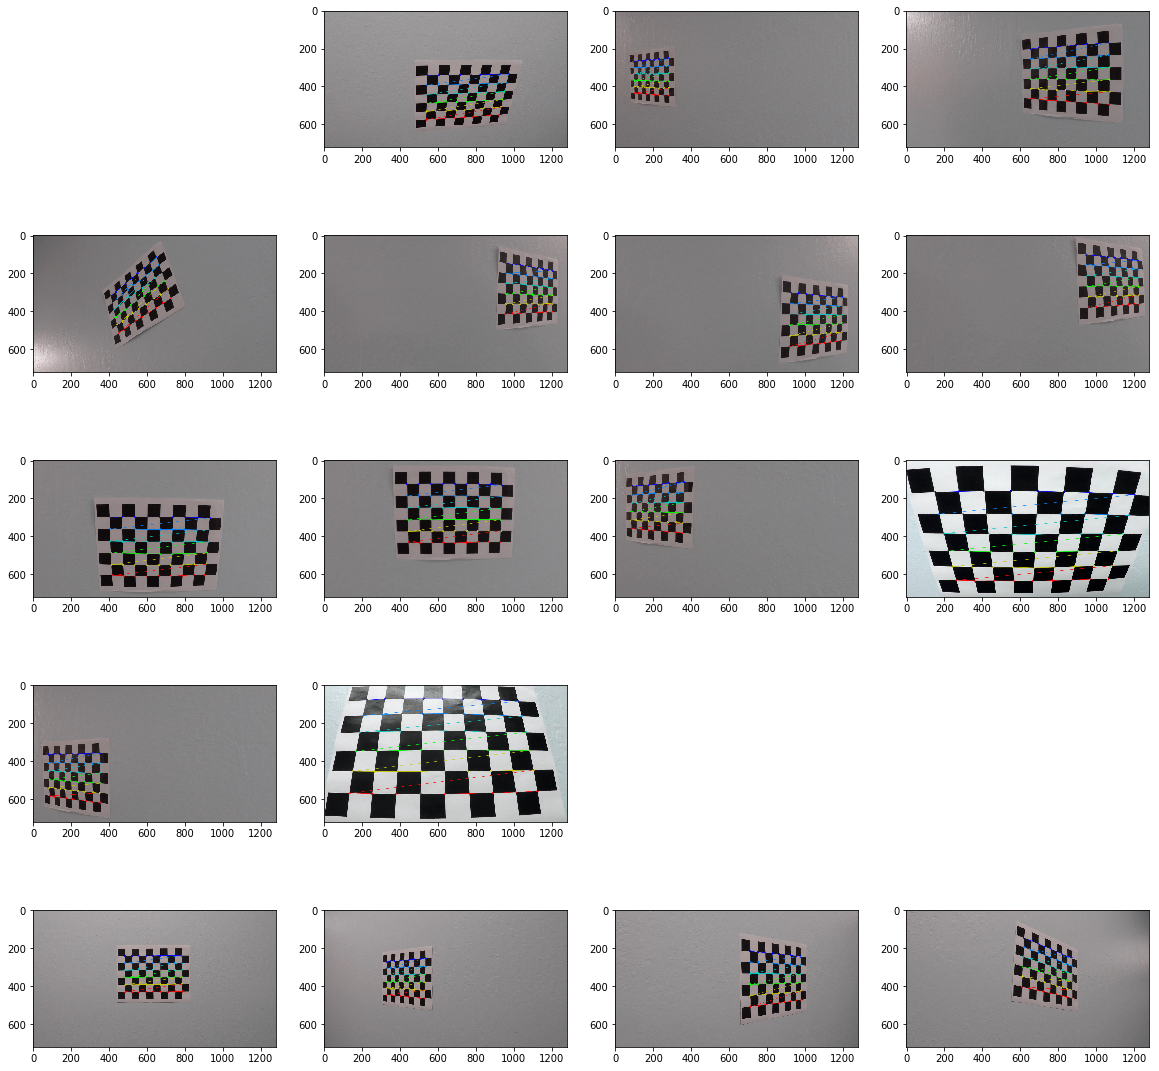

In [194]:
corner_detection()

## Step 2 : Distortion correction to raw images

In [195]:
def read_data(file):
    # Read in the saved objpoints and imgpoints
    dist_pickle = pickle.load( open( file, "rb" ) )
    objpoints = dist_pickle["objpoints"]
    imgpoints = dist_pickle["imgpoints"]
    return objpoints, imgpoints

In [196]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

### Test Distortion correction on chessboard image

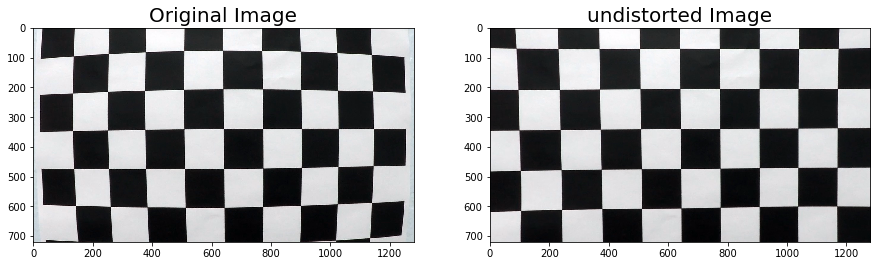

In [201]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,4))
img = cv2.imread('camera_cal/calibration1.jpg')
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 20)
objpoints, imgpoints = read_data("camera_cal/cal_dist_pickle.p")
dst = cal_undistort(img, objpoints, imgpoints)
ax2.imshow(dst)
ax2.set_title('undistorted Image', fontsize = 20)
plt.show()

# write undistorted image in output_images folder
f.savefig('output_images/Undistorted_chessboard.jpg')

### Test Distortion correction on image road 

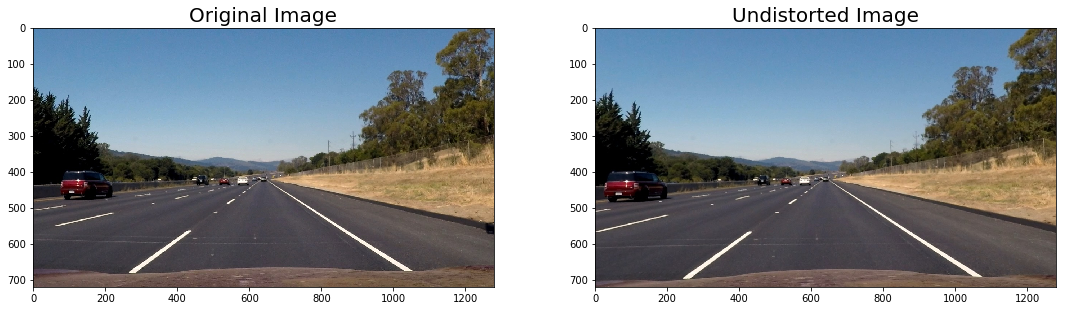

In [159]:
# Read in an image
img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Read in the saved objpoints and imgpoints
objpoints, imgpoints = read_data("camera_cal/cal_dist_pickle.p")
# returns the undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)


# Plot the result
show_image(img, 'Original Image', undistorted, 'Undistorted Image')

# write undistorted image in output_images folder
plt.savefig('output_images/Undistorted_road.jpg')

# Step 3: Gradient and color Threshold





## Gradient in the X Direction

abs_sobel_tresh(): Method applies the Sobel operation in the x or y direction and returns a binary image

In [160]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3,thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

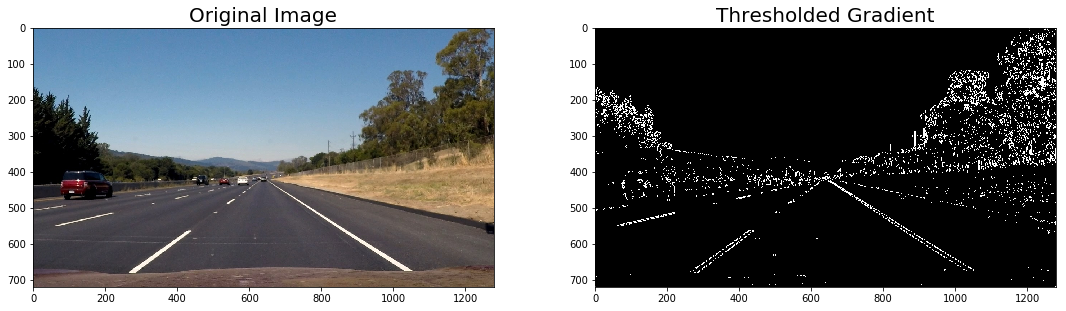

In [161]:
# Run the function
grad_binary = abs_sobel_thresh(img, orient='x', thresh=(20, 100))
# Plot the result
show_image(img, 'Original Image', grad_binary, 'Thresholded Gradient',cmap = 'gray')

# write Thresholded Gradient image in output_images folder
plt.savefig('output_images/Thresholded_Gradient.jpg')

## Magnitude of the Gradient

mag thresh(): Method finds the magnitude of the Sobel operation in th x and y direction and returns binary image

In [162]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

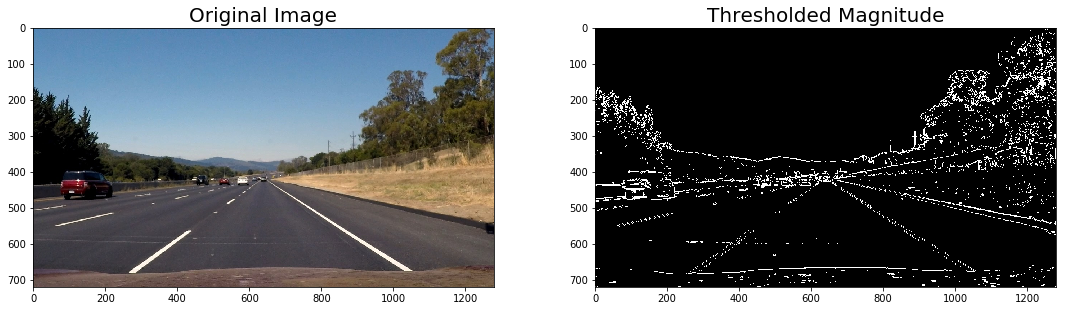

In [163]:
# Run the function
mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
show_image(img, 'Original Image', mag_binary, 'Thresholded Magnitude',cmap = 'gray')

# write Thresholded Magnitude image in output_images folder
plt.savefig('output_images/Thresholded Magnitude.jpg')

## Direction of the Gradient

dir_thresh(): Method finds the direction of gradient of the Sobel operation and returns a binary image

In [164]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

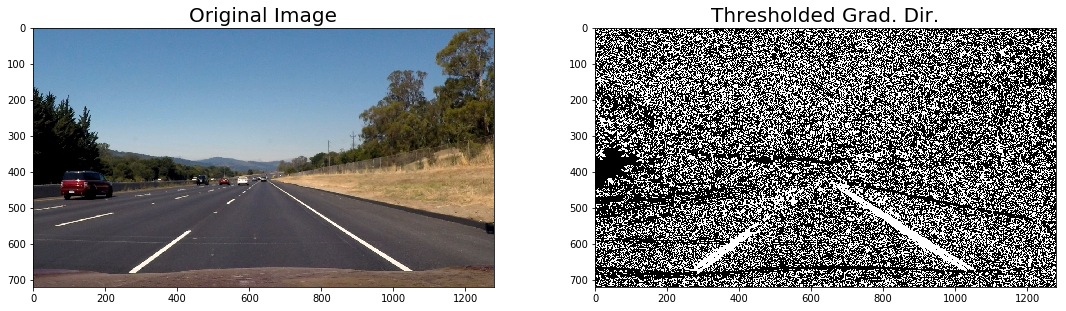

In [165]:
# Run the function
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
show_image(img, 'Original Image', dir_binary, 'Thresholded Grad. Dir.',cmap = 'gray')

# write Thresholded gradient direction image in output_images folder
plt.savefig('output_images/Direction_Gradient.jpg')

# Apply HLS Color threshold

hls_tresh(): Methods converts the image into HLS color splace and uses the S-channel (saturation) for thresholding and returns a binary image

In [166]:
def hls_thresh(image, thresh= (0,255)):
    """ write pydoc """
    # Reduce some noises
    image = cv2.GaussianBlur(image,(5,5),0)
    # Convert image to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Binary image mask
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output

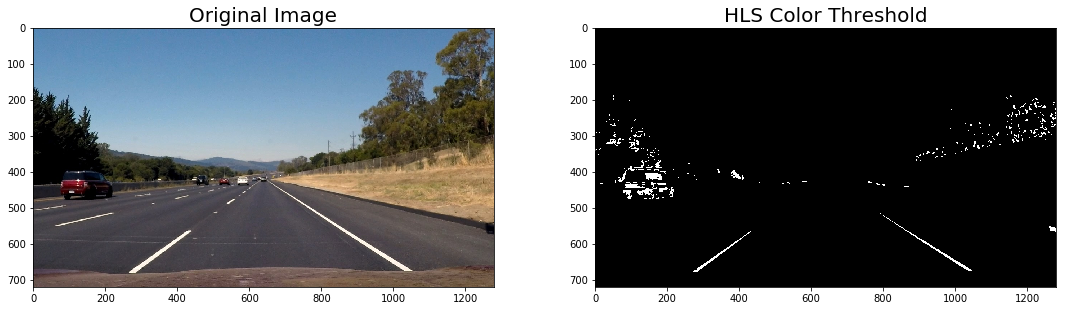

In [167]:
# Run the function
binary_hls = hls_thresh(img, thresh=(170, 255))
# Plot the result
show_image(img, 'Original Image', binary_hls, 'HLS Color Threshold',cmap = 'gray')

# write HLS Threshold image in output_images folder
plt.savefig('output_images/HLS_Threshold.jpg')

# Apply LUV + LAB + HLS  Color threshold

Here with have a better output with a conbination of color threshold.

In [168]:
def LUV_LAB_HLS(image, thresh = (150,255)):
    image = cv2.GaussianBlur(image,(5,5),0)
    
    l_channel = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)[:,:,0]
    b_channel = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)[:,:,2] 
    s_channel = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    
    # white lines(LUV)
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 210) & (l_channel <= 255)] = 1
    #yellow lines(LAB)
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= 150) & (b_channel <=255)] = 1
    #yellow Lines(HLS)
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > 170) & (s_channel <= 255)] = 1
        
    """COMBINE COLOR SPACE"""
    color_threshold = np.zeros_like(b_binary)
    color_threshold[(l_binary == 1)|(b_binary == 1)| (s_binary == 1)] = 1
    return color_threshold

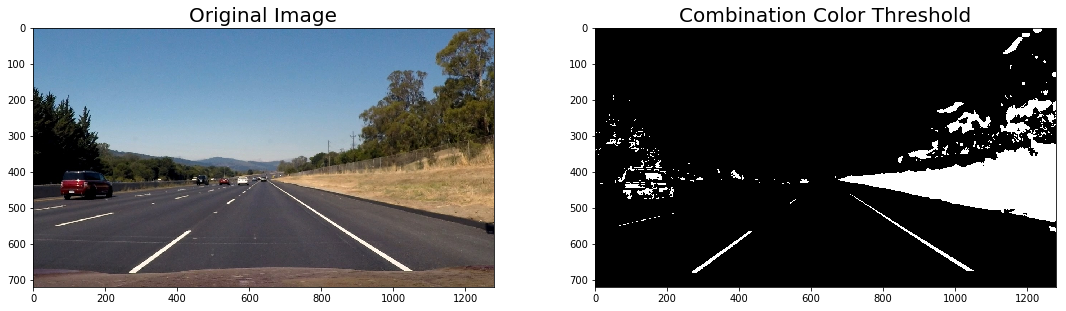

In [169]:
# Run the function
binary_luv_lab_hls = LUV_LAB_HLS(img, thresh=(150, 255))
# Plot the result
show_image(img, 'Original Image', binary_luv_lab_hls, 'Combination Color Threshold',cmap = 'gray')

# write Combination_Color_Threshold in output_images folder
plt.savefig('output_images/Combination_Color_Threshold.jpg')

# Combined color and gradient thresholds for lane detection.
I used a combination of gradient and color thresholds to generate a binary image

In [170]:
import cv2
def color_gradient_threshold(img):
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 200))
    
    #binary_hls = hls_thresh(img, thresh= (170,255))
    binary_luv_lab_hls = LUV_LAB_HLS(img, thresh=(150, 255))
    
    # Combine the two binary thresholds
    combined = np.zeros_like(gradx)
    combined[((gradx == 1) | (binary_luv_lab_hls == 1))] = 1
    
    return combined
      

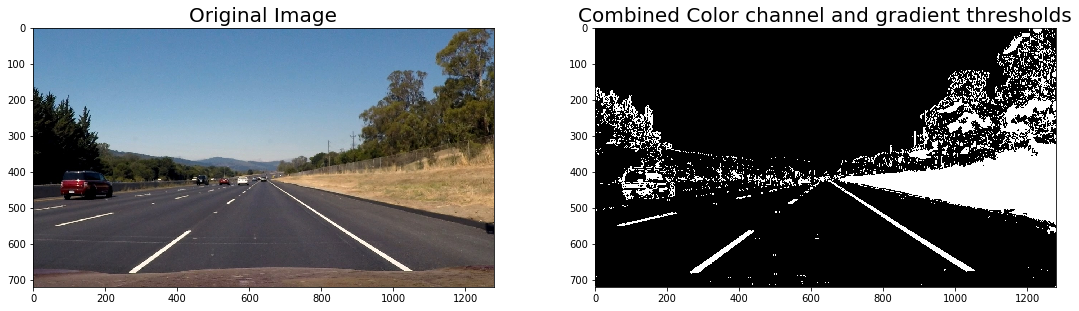

In [171]:
# Run the function
combined_binary = color_gradient_threshold(img)

# Plot the result
show_image(img, 'Original Image', combined_binary, 'Combined Color channel and gradient thresholds',cmap = 'gray')

# Write ombination color and gradient Threshold image in output_images folder
plt.savefig('output_images/Combination_Color_Gradient_Threshold.jpg')

# Step 4: Perspective Transform


In order to compute the perspective transform, points of a given image have to be mapped to different points in the same image. The perspective transform of interest for the lane finding algorithm is the bird's-eye (top-down) view of the lane ahead. This is extremely useful to calculate the curvature of a given lane. The steps to compute the perspective transform to achieve a bird's-eye view are the following:
Determine source points, coordinates of the region of the image you want to transform
Determine destination points, coordinates of the region you want to map your source points to
Use the OpenCV function cv2.getPerspectiveTransform to get M, the transform matrix
Use the OpenCV function cv2.warpPerspective to apply M and warp image to a top-down view
Note: An important assumption we make is that the road is flat



In [172]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def warp(img):
    height,width = img.shape[:2]
    width_Offset = 240
    height_Offset = 0
    img_size = (img.shape[1], img.shape[0])

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[(592, 450), (180, height), (1130, height), (687, 450)]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[(width_Offset, height_Offset), (width_Offset, height), (1040, height), (1040, height_Offset)]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image 
    return warped


In [202]:
height,width = img.shape[:2]
print(height)

720


### Test_1 on straight line

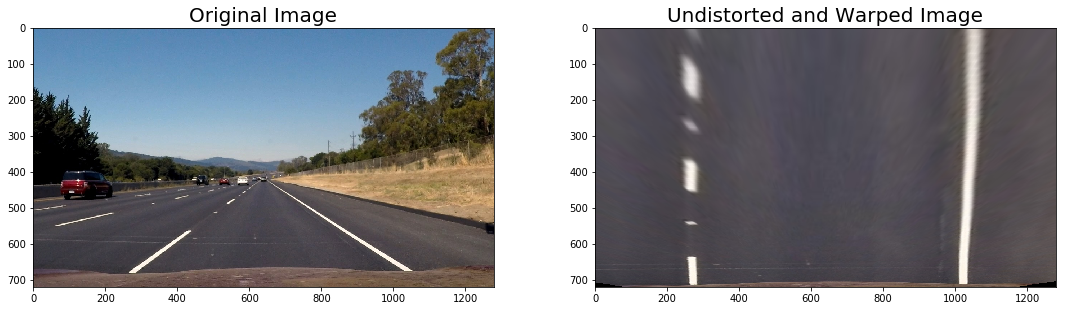

In [173]:
# returns the undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

# Get perspective transform
top_view = warp(undistorted)

# Plot the result
show_image(img, 'Original Image', top_view, 'Undistorted and Warped Image')

# Write undistorted and warped  image in output_images folder
plt.savefig('output_images/Undistorted and Warped Image.jpg')

### Test_2 on curved line

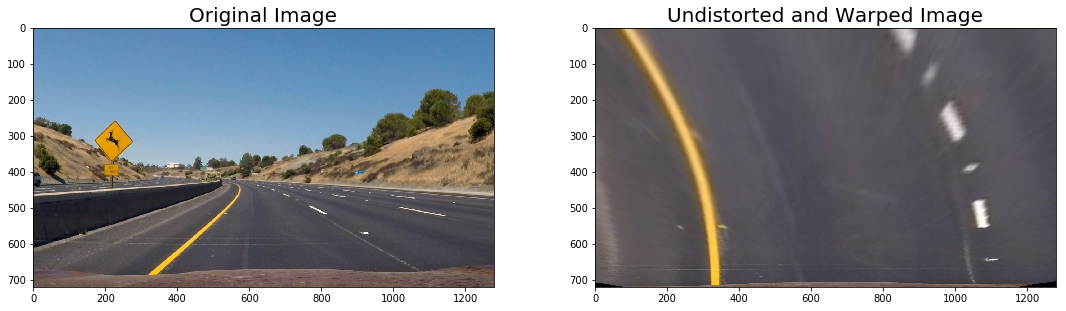

In [174]:
height,width = img.shape[:2]
width_Offset = 240
height_Offset = 0


# Read curved image
img_curve =  cv2.imread('test_images/test2.jpg')
img_curve = cv2.cvtColor(img_curve, cv2.COLOR_BGR2RGB)


# returns the undistorted image
undistorted_curve = cal_undistort(img_curve, objpoints, imgpoints)

# Get perspective transform
top_view = warp(undistorted_curve)



# Plot the result
show_image(img_curve, 'Original Image', top_view, 'Undistorted and Warped Image')

# Write undistorted and warped curved image in output_images folder
plt.savefig('output_images/Undistorted and Warped Curved Image.jpg')

# Image pipeline

In [175]:
def image_pipeline(img,objpoints,imgpoints):
    # Read image
    img =  cv2.imread('test_images/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # returns the undistorted image
    undistorted_img = cal_undistort(img, objpoints, imgpoints)
    # returns Combined color and gradient thresholds
    combined_binary = color_gradient_threshold(undistorted_img)
    #combined_binary = get_binary_image(undistorted_img)
    # Get perspective transform
    top_view = warp(combined_binary)
    
    return top_view
    

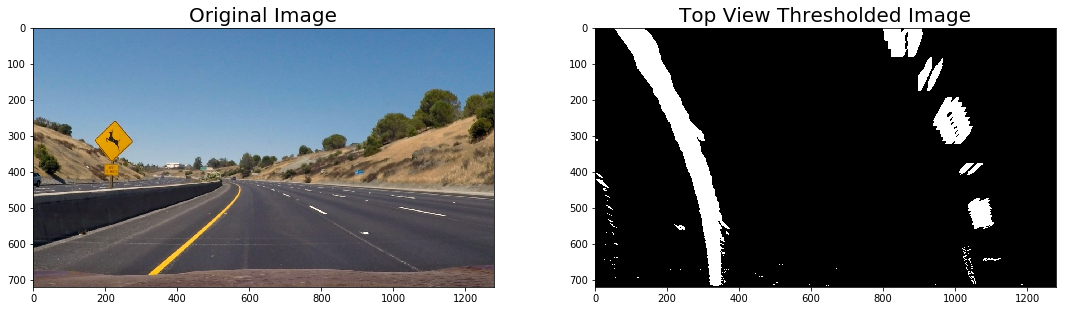

In [176]:
# returns image pipeline output
top_view = image_pipeline('test2.jpg',objpoints,imgpoints)

# Plot the result
show_image(img_curve, 'Original Image', top_view, 'Top View Thresholded Image',cmap = 'gray')


# Write undistorted, warped and thresholded curved image in output_images folder
plt.savefig('output_images/Undistorted, Warped and Thresholded Curved Image.jpg')

# STEP 5 : Detect lane pixels and fit to find the lane boundary

The perspective transform, then application of color and gradient thresholding enable us to clearly identify the position of the lanes on the bird's eye view image. However, we also notice some small dots and other visual artifacts. We must build a robust lane finder in order not to be caught by these glitches.

### Histogram

The first step for finding the lines was to get a histogram of the frequency of pixels in the lower half of the image. This is used for finding the candidate x,y points where we will assume the center of the lines will be located.

In [177]:
def hist(top_view):
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = top_view[top_view.shape[0]//2:,:]
    # The highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram


In [178]:
# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
top_view = image_pipeline('test2.jpg',objpoints,imgpoints)/255

# Create histogram of image binary activations
histogram = hist(top_view)

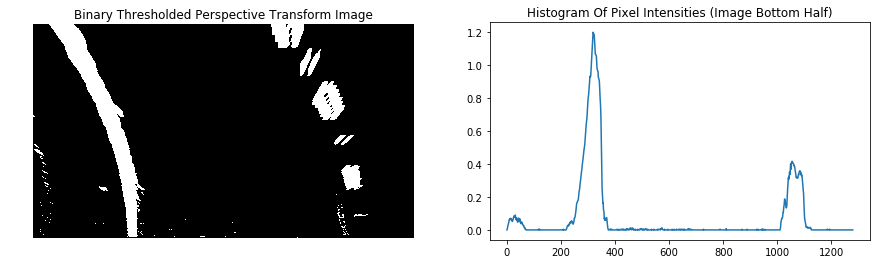

In [188]:
# Visualize Binary Thresholded Perspective Transform
fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].imshow(top_view, cmap='gray')
ax[0].axis("off")
ax[0].set_title("Binary Thresholded Perspective Transform Image")
# Visualize the resulting histogram
ax[1].plot(histogram)
ax[1].set_title("Histogram Of Pixel Intensities (Image Bottom Half)")

# Display images
plt.show()

# Write Histogram in output_images folder
fig.savefig('output_images/Histogram.jpg')

### Implement Sliding Windows and Fit a Polynomial

Now we can use the two highest peaks from our histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go. 

5 steps to reach this goal:

1. We split the histogram into two sides
2. Set up windows and window hyperparameters
3. Iterate through nwindows to track curvature
4. Fit a polynomial
5. Visualization

### Sliding windows

Below is an example of how a frame is processed after the perspective transfrom is applied using the sliding window method above. After detecting all the relevant pixels in each line these can be used to fit a second order polynomial for each line as seen in yellow in the picture below. 

In [180]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2



def fit_polynomial(binary_warped, show = False):
    # Find our lane pixels first
        # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if show == True:
        # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        else:
            pass
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    if show == True:
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    else:
        pass

    return out_img,left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty,left_fit, right_fit




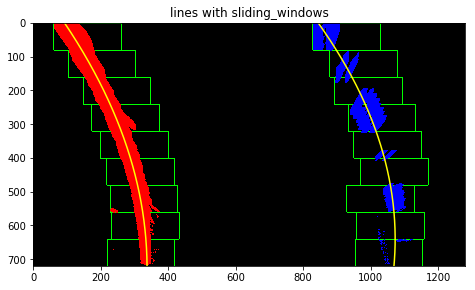

In [181]:
out_img,_, _, _, _, _, _, _,_,_ = fit_polynomial(top_view, True)


# View your output
plt.imshow(out_img.astype(np.uint8))
plt.title('lines with sliding_windows')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Write sliding windows in output_images folder
plt.savefig('output_images/sliding_windows.jpg')

### Skip the sliding windows 

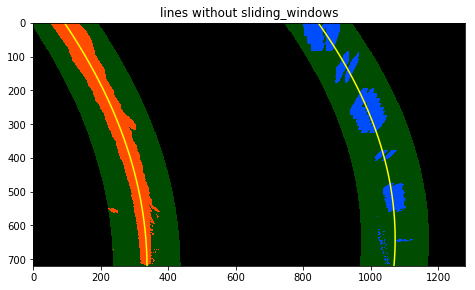

In [182]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt





def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Fit new polynomials
    _,left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty,left_fit, right_fit = fit_polynomial(binary_warped)
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    #out_img,left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty, _, _ = fit_polynomial(binary_warped)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

    return result, ploty, left_fit, right_fit

# Run image through the pipeline
result,_, _, _ = search_around_poly(top_view)

# View your output
plt.imshow(result.astype(np.uint8))
plt.title('lines without sliding_windows')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Write lines without sliding windows in output_images folder
plt.savefig('output_images/without_sliding_windows.jpg')

# Calculate Radius of Curvature and Camera Offset

In [183]:
import numpy as np


    
def measure_curvature_pixels(binary_warped):
    '''
    Calculates the curvature of polynomial functions in pixels and camera offset.
    '''
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    _,left_fitx, right_fitx, leftx, lefty, rightx, righty, plot_y,left_fit, right_fit = fit_polynomial(binary_warped)
    
    # Generate  and x, y plotting points along the height of the entire frame
    #plot_y = np.linspace(0, 719, num=720)
    #left_fitx = np.polyval(left_fit, plot_y)
    #right_fitx = np.polyval(right_fit, plot_y)

    # Fit new polynomial in real world space (meters)
    left_fit_m = np.polyfit(plot_y*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_m = np.polyfit(plot_y*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(plot_y)
    
    # Calculate the new radian of curvature
    left_curverad = ((1 + (2*left_fit_m[0]*y_eval*ym_per_pix + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    right_curverad = ((1 + (2*right_fit_m[0]*y_eval*ym_per_pix + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
    
    
    height = binary_warped.shape[0]
    width = binary_warped.shape[1]
    
    left_fit_position = np.polyval(left_fit, height)
    right_fit_position = np.polyval(right_fit, height)
      
    # Camera location (center of the frame)
    image_center = width // 2
    
    lane_center = (left_fit_position + right_fit_position)//2
    
    #diff = np.absolute(right_fit_position - left_fit_position)
    #scale = xm_per_pix/ diff
    vehicle_position = (image_center - lane_center) * xm_per_pix
    #vehicle_position = (image_center - np.mean([left_fit_position,right_fit_position]))* scale
       
    return left_curverad, right_curverad, vehicle_position


# Calculate the radius of curvature in pixels for both lane lines and vheicle position
left_curverad, right_curverad, vehicle_position = measure_curvature_pixels(top_view)

print('left curvature: ',left_curverad,'m')
print('right curvature: ', right_curverad,'m')
print('vehicle position :  {:04.2f}'.format(vehicle_position), 'm')

left curvature:  355.3770828307262 m
right curvature:  295.35348832034515 m
vehicle position :  -0.33 m


In [184]:
def draw_lane_curvature_text(result, left_curverad, right_curverad, vehicle_position): 
    if vehicle_position > 0:
        closest = ' To the right of centre'
    else:
        closest = ' To the left of centre'
    
    cv2.putText(result, "Left curvature: %.1f m." % left_curverad, (300, 50), cv2.FONT_HERSHEY_DUPLEX, 1.1, (255,255,0), 2)
    cv2.putText(result, "Right curvature: %.1f m." % right_curverad, (300, 100), cv2.FONT_HERSHEY_DUPLEX, 1.1, (255,255,0), 2)
    cv2.putText(result, "vehicle position: %.2f m." % abs(vehicle_position) + closest, (300,150), cv2.FONT_HERSHEY_DUPLEX, 1.1, (255,255,0), 2)

# Drawing Detected lane Back on the Road

We have obtained measurements of the line position in warped space. To visualize the detection we will project the detection back on the road using the plotting points obatined from the line fits: left_fitx, right_fitx and ploty

In [185]:
def fit_curves(left_x, left_y, right_x, right_y):
    # Fit second order polynomial
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit =  np.polyfit(right_y, right_x, 2)
    return left_fit, right_fit

def generate_plotting_values(left_fit, right_fit, image_size):
    # Generate y values for plotting
    ploty = np.linspace(0, image_size[0]-1, image_size[0])
    
    # Evaluate x values for plotting
    left_fitx =  np.polyval(left_fit, ploty)
    right_fitx = np.polyval(right_fit, ploty)
    
    return ploty, left_fitx, right_fitx

In [186]:
def inverse_perspective_transform(img):
    
    # Read in the saved objpoints and imgpoints
    objpoints, imgpoints = read_data("camera_cal/cal_dist_pickle.p")
    
    # Undistorted image
    img = cal_undistort(img, objpoints, imgpoints)
    
    height,width = img.shape[:2]
    width_Offset = 240
    height_Offset = 0
    img_size = (img.shape[1], img.shape[0])

    # Source points: trapezoid verteces
    src = np.float32([[(592, 450), (180, height), (1130, height), (687, 450)]])
    
    # Destination points
    dst = np.float32([[(width_Offset, height_Offset), (width_Offset, height), (1040, height), (1040, height_Offset)]])
    

    # Given src and dst points, calculate the inverse perspective transform matrix
    M_inv = cv2.getPerspectiveTransform(dst,src)


    # Return the resulting  
    return M_inv

In [187]:
def project_lane(image, left_fit, right_fit):
    
    # Create new image to draw lines on
    warped_zero = np.zeros_like(image[:,:,0]).astype('uint8')
    color_warped = np.dstack((warped_zero, warped_zero, warped_zero))
    
    # Evaluate plotting points
    plot_y, left_fitx, right_fitx = generate_plotting_values(left_fit, right_fit, image.shape)
    
    #center_fit = (left_fit + right_fit)/2
    #center_fitx = center_fit[0]*ploty**2 + center_fit[1]*ploty + center_fit[2]
    
    # Create a polygon to represent the detected lane
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, plot_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, plot_y])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warped, np.int_([pts]), (255,0, 0))
    
    ## Recast the x and y points into usable format for cv2.fillPoly()
    #pts_center = np.array([np.transpose(np.vstack([center_fitx, ploty]))])
    #pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    #pts = np.hstack((pts_center, pts_right))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(color_warp, np.int_([pts]), (255,0, 0))
    
    # inverse perspective transform
    M_inv = inverse_perspective_transform(image)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warped = cv2.warpPerspective(color_warped, M_inv, (image.shape[1], image.shape[0])) 
    
    

    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, new_warped, 0.3, 0)
    
    
   
    return result

# --------------------------------------------------------------------------------------------------------------

#  Pipeline

In [67]:
# Display images of pipeline
def show_images_pipeline(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    plt.figure(figsize=(15, 14))
    
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        image =  cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        process_image = process(image)    
        cv2.imwrite('output_images/'+str(i)+'.jpg', cv2.cvtColor(process_image,cv2.COLOR_BGR2RGB))
        plt.imshow(process_image)
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

def region_of_interest(img):
    mask = np.zeros_like(img)   
    
    imshape = img.shape    
    if len(imshape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    vertices = np.array([[(0,imshape[0]),(imshape[1]*.48, imshape[0]*.58), (imshape[1]*.52, imshape[0]*.58), (imshape[1],imshape[0])]], dtype=np.int32)              
    cv2.fillPoly(mask, vertices, ignore_mask_color)   
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def image_offset(img, final_test_image):
    
    undistorted_img = cal_undistort(img, objpoints, imgpoints)
    combined_binary = color_gradient_threshold(undistorted_img)
    #combined_binary = get_binary_image(undistorted_img)
    
    roiImg = region_of_interest(combined_binary)
    resize_roi = cv2.resize(np.dstack((roiImg, roiImg, roiImg))*255,(192,154))
    
    undist = warp(roiImg)
    resize_warped = cv2.resize(np.dstack((undist, undist, undist))*255,(192,154))
                           
    
    
    x_offset = 50
    y_offset = 50
    final_test_image[y_offset:y_offset+resize_roi.shape[0],x_offset:x_offset+resize_roi.shape[1]] = resize_roi
    
    x_offset = 50
    y_offset = 250
    final_test_image[y_offset:y_offset+resize_warped.shape[0],x_offset:x_offset+resize_warped.shape[1]] = resize_warped
    
    #x_offset = 50
    #y_offset = 500
    #final_test_image[y_offset:y_offset+birds_view.shape[0],x_offset:x_offset+birds_view.shape[1]] = birds_view
    
    return (final_test_image)

In [68]:
def process(img): 
    
    # Read in the saved objpoints and imgpoints
    objpoints, imgpoints = read_data("camera_cal/cal_dist_pickle.p")
    
    # returns the undistorted image
    undistorted_img = cal_undistort(img, objpoints, imgpoints)
    
    # returns Combined color and gradient thresholds
    combined_binary = color_gradient_threshold(undistorted_img)
    #combined_binary = get_binary_image(undistorted_img)
    
    roiImg = region_of_interest(combined_binary)
    
    # Get perspective transform
    top_view = warp(roiImg)
    
    # Calculate the radius of curvature in pixels for both lane lines and vehicle position
    left_curverad, right_curverad, vehicle_position = measure_curvature_pixels(top_view)
    
    # Detect x and y coordinates for the lane
    out_img,left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty,left_fit, right_fit =  fit_polynomial(top_view, show = False)

    # Fit detected left and right x and y coordinates
    left_fit, right_fit = fit_curves(leftx, lefty, rightx, righty)

    # returns the undistorted image
    undistorted = cal_undistort(img, objpoints, imgpoints)

    # Project lane onto the original image
    final_test_image = project_lane(undistorted, left_fit, right_fit)
    
    # Draw little images on the main screen
    final_test_image = image_offset(img, final_test_image)
    
    # Print left, right curvature and vehicle position
    draw_lane_curvature_text(final_test_image, left_curverad, right_curverad, vehicle_position)
    
    
    return final_test_image

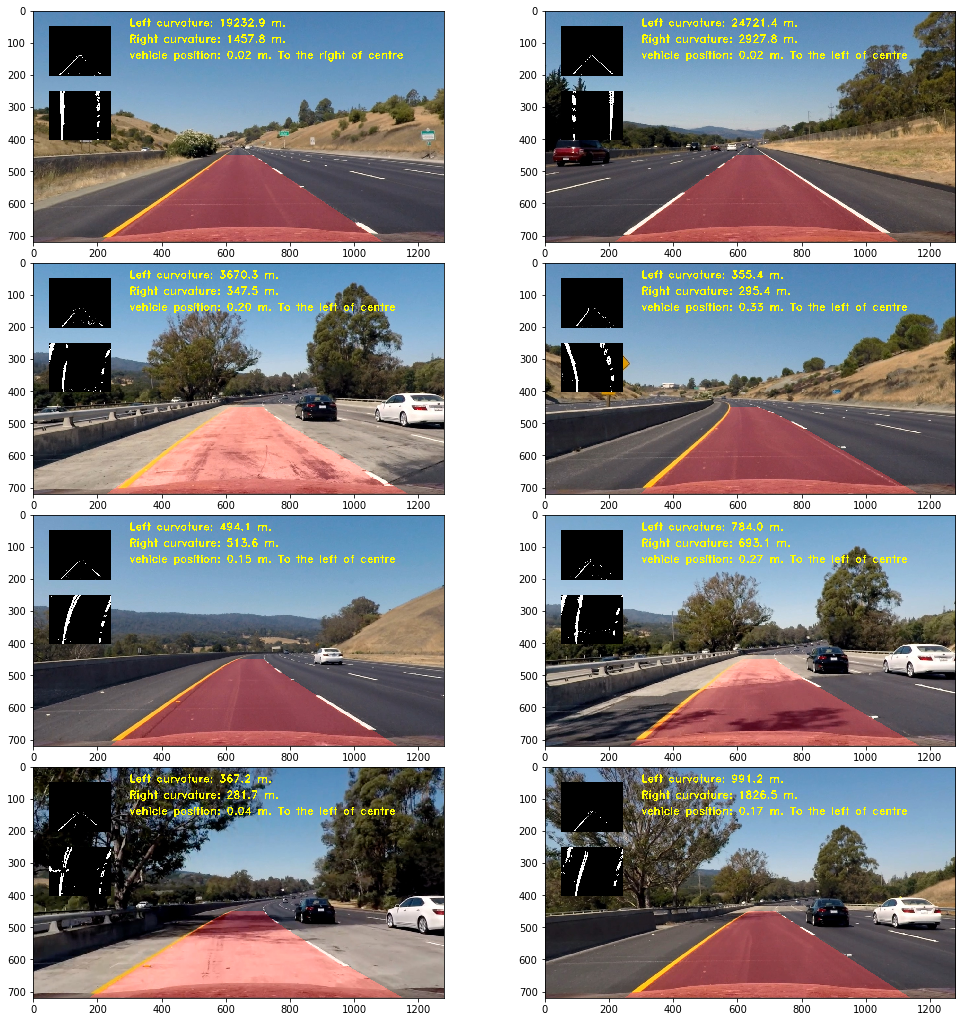

In [70]:
images = glob.glob('test_images/*.jpg')  

show_images_pipeline(images)

# Test pipeline on video

In [197]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [198]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/project_video.mp4
Wall time: 2h 42min


In [199]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Challenge Video

In [200]:
white_output = 'test_videos_output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("test_videos/challenge_video.mp4")
white_clip = clip2.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/challenge_video.mp4.
Moviepy - Writing video test_videos_output/challenge_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_video.mp4
Wall time: 42min 55s


In [201]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))